In [1]:
%load_ext autoreload

In [11]:
%autoreload
import tasks.lstm_problems as task
import utils.seq_clf_batch as util

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim

%matplotlib inline

# The Task

Given a list of pairs where the first item is a real number in the range (-1, 1) and the second item is flag in the set {-1, 0, 1}, the two numbers in the list that are flagged with a 1 are takens as X_1 and X_2 with the target being Y = 0.5 + (X_1 + X_2)/4.0. 

This task is described in and the implementation is givne by the following sources respectively:

- Sepp Hochreiter and Jürgen Schmidhuber. "Long short-term memory." Neural computation 9.8 (1997): 1735-1780

- https://github.com/craffel/lstm_problems

In [3]:
test_data, test_answer, test_bool = task.add(10, 1000, 100)
train_data, train_answer, train_bool = task.add(10, 100000, 100)

# The Network

This architecture is based on the 2015 work by Raffel and Ellis cited below. Here I am using this architecture to demonstrate attention in its simplest form.

This architecture has two main parts as follows:
- The attention layer, which produces a weighted average of the time steps with weights learned.
- The output layer, which takes the resulting context vector to predict the target.

C. Raffel and D. P. W. Ellis, “Feed-Forward Networks with Attention Can Solve Some Long-Term Memory Problems,” arXiv:1512.08756 [cs], Dec. 2015.


In [4]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.attn = nn.Linear(self.input_size, 1)
        self.out = nn.Linear(self.input_size, 1)
            
    def forward(self, x):
        batch_size, timesteps, input_size = x.shape
        
        # Reshape to apply embedding to each input independently
        y = [x[i] for i in range(batch_size)]
        
        # Compute weights
        w = [self.attn(y[i]) for i in range(batch_size)]
        w = [F.softmax(i, 0) for i in w]
        w = torch.cat(w, 0).view(batch_size, timesteps, 1)
        y = torch.cat(y, 0).view(batch_size, timesteps, 2)
        
        # Combine
        z = w.transpose(1, 2).bmm(y).squeeze(1)
        
        # Compute output
        z = F.relu(self.out(z))
            
        return z, w

# Training

In [5]:
net = Net(2)
util.train(net, train_data, train_answer, batch_size=32, epochs=1, print_every=1000)

Epoch 1 of 1
Average batch loss over 1 batchs: 0.0581
Average batch loss over 1000 batchs: 0.0371
Average batch loss over 2000 batchs: 0.0266
Average batch loss over 3000 batchs: 0.0191


# Test Set Evaluation

Accuracy: 0.4000


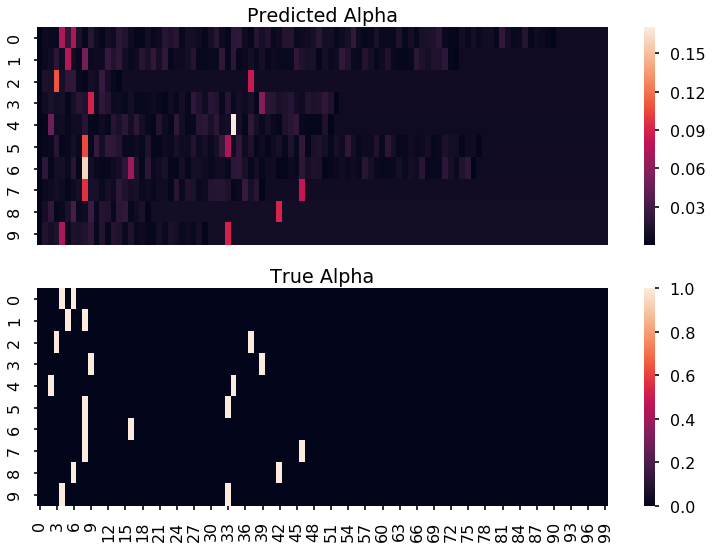

In [12]:
util.evaluate_randomly(test_data, test_answer, net)